In [2]:
import numpy as np
import pandas as pd

In [3]:
P1_data = pd.read_csv('dataset.csv')

In [4]:
P1_data

,age,course,likeStats,y
0,20,1,0,0
1,18,1,1,1
2,15,0,1,1
3,16,0,0,1
4,17,1,1,1
5,21,1,0,0
6,23,1,0,0
7,15,1,1,0
8,17,0,1,1
9,17,1,0,0


In [5]:
theta = np.array([0.05, -3, 2.5])
theta0 = 0.3

In [6]:
features = list(P1_data.columns)[:-1]

In [7]:
P1_linear = P1_data.copy()
P1_sigmod = P1_data.copy()

In [8]:
P1_linear['result'] = P1_linear.apply(lambda x: np.dot(x[features], theta) + theta0, axis=1)

In [9]:
P1_sigmod['result'] = P1_sigmod.apply(lambda x: 1 / (1 + np.exp(-np.dot(x[features], theta) - theta0)), axis = 1)

In [10]:
def evaluate_higher(data, threshold):
    data_copy = data.copy()
    data_copy['predict'] = data_copy['result'].apply(lambda x: 1 if x >= threshold else 0)
    data_copy['correct'] = data_copy.apply(lambda x: 1 if x['predict'] == x['y'] else 0, axis = 1)
    return sum(data_copy['correct'])
    

In [11]:
def evaluate_lower(data, threshold):
    data_copy = data.copy()
    data_copy['predict'] = data_copy['result'].apply(lambda x: 0 if x <= threshold else 1)
    data_copy['correct'] = data_copy.apply(lambda x: 1 if x['predict'] == x['y'] else 0, axis = 1)
    return sum(data_copy['correct'])

In [12]:
def search_threshold(data):
    top_correct = 0
    top_correct_threshold_high = []
    top_correct_threshold_low = []
    for index, item in data.iterrows():
        correct = evaluate_higher(data, item['result'])
        if correct > top_correct:
            top_correct = correct
            top_correct_threshold_high = [item['result']]
        elif correct == top_correct:
            top_correct_threshold_high.append(item['result'])
    top_correct = 0
    for index, item in data.iterrows():
        correct = evaluate_lower(data, item['result'])
        if correct > top_correct:
            top_correct = correct
            top_correct_threshold_low = [item['result']]
        elif correct == top_correct:
            top_correct_threshold_low.append(item['result'])        
                
    return top_correct, top_correct_threshold_high, top_correct_threshold_low    

In [13]:
search_threshold(P1_linear)

(10, [0.65000000000000013], [0.55000000000000004])

In [14]:
def evaluate_matrix(data, threshold):
    data_copy = data.copy()
    data_copy['predict'] = data_copy['result'].apply(lambda x: 0 if x <= threshold else 1)
    matrix_frame = {'True' : pd.Series([0, 0], index= ['True', 'False']),
                    'False' : pd.Series([0, 0], index= ['True', 'False'])}
    confusion_table = pd.DataFrame(matrix_frame)
    for index, item in data_copy.iterrows():
        if item['predict'] == item['y']:
            if item['y'] == 1:
                confusion_table['True']['True'] += 1
            else:
                confusion_table['False']['False'] += 1
        else:
            if item['y'] == 0:
                confusion_table['True']['False'] += 1
            else:
                confusion_table['False']['True'] += 1
    return confusion_table              
                    
            

In [50]:
P1_linear_confusion = evaluate_matrix(P1_linear, 0.55)
print P1_linear_confusion

       False  True
True       0     5
False      5     0


In [16]:
search_threshold(P1_sigmod)

(10, [0.65701046267349883], [0.63413559101080075])

In [17]:
P1_sigmod_confusion = evaluate_matrix(P1_sigmod, 0.64)
print P1_sigmod_confusion

       False  True
True       0     5
False      5     0


In [18]:
P1_sigmod_percision = P1_sigmod_confusion['True']['True'] / float(sum(P1_sigmod_confusion['True']))
print P1_sigmod_percision

1.0


In [19]:
P1_sigmod_recall = P1_sigmod_confusion['True']['True'] / float(sum(P1_sigmod_confusion.T['True']))
print P1_sigmod_recall

1.0


In [20]:
P1_sigmod_F1 = 2 * (P1_sigmod_percision * P1_sigmod_recall) / float(P1_sigmod_percision + P1_sigmod_recall)
print P1_sigmod_F1

1.0


In [53]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib

In [75]:
#ROC
def ROC(data, n_points):
    threshold_lowerbond = min(data['result']) - 1
    threshold_higherbond = max(data['result']) + 1
    threshold = np.linspace(threshold_higherbond, threshold_lowerbond, n_points)
    positive_num = sum(data['y'])
    negative_num = len(data['y']) - positive_num
    TPR = []
    FPR = []
    for i, ithreshold in enumerate(threshold):
        confusion_matrix = evaluate_matrix(data, ithreshold)
        TPR.append(confusion_matrix['True']['True'] / float(positive_num))
        FPR.append(confusion_matrix['True']['False'] / float(negative_num))
#         print confusion_matrix, ithreshold
    PR_total = sorted(zip(FPR, TPR))
    TPR = [x[1] for x in PR_total]
    FPR = [x[0] for x in PR_total]
#     fig, ax = plt.subplot(111)
#     plt.scatter(FPR,TPR)  
    plt.plot(FPR,TPR, '-o')
    plt.xlim(-0.2,1.2)
    plt.ylim(-0.2,1.2)
    plt.show()
#     from matplotlib.backends.backend_pdf import PdfPages
#     pp = PdfPages('ROC.pdf')
#     plt.savefig(pp, format = 'pdf')
#     pp.close
   
    return TPR,FPR    
        
        
    
    

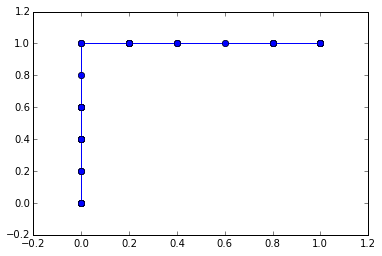

In [76]:
TPR, FPR = ROC(P1_linear, 360)

In [24]:
#AUC
TPR_array = np.array(TPR)
FPR_array = np.array(FPR)
area = np.dot((FPR_array[1:] - FPR_array[:-1]),TPR[1:])
print area

0.4


In [48]:
def entropy(p, q):
    if p == 0 or q == 0:
        return 0
    return -p*np.log2(p) - q * np.log2(q)

In [49]:
#x1
x1_gain = entropy(0.5,0.5) - 0.4 * entropy(0,1) - 0.6 * entropy(5/float(6), 1/float(6))
print x1_gain
x2_gain = entropy(0.5,0.5) - 0.5 * entropy(0.6,0.4) - 0.5 * entropy(0.4, 0.6)
print x2_gain
x3_gain = entropy(0.5,0.5) - 0.6 * entropy(4/float(6),2/float(6)) - 0.4 * entropy(0.25, 0.75)
print x3_gain

0.609986547011
0.0290494055453
0.124511249784
